In [1]:
# 필요 모듈 로딩
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

import FinanceDataReader as fdr
import pandas_datareader as pdr
import yfinance as yf

from module import stationarity_adf_test, stationarity_kpss_test

from IPython.display import display_html
def display_side_by_side(*args):
    """여러 데이터프레임 비교가 쉽게 옆쪽으로 표시한다"""
    html_str=''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

# 공적분

\begin{align*}
\text{Example of Cointegration} \\
\text{Y1: Random Walk with I(1)} && Y_{1t} &= Y_{1t-1} + e_{1t} \\
\text{Y2: Random Walk with I(1)} && Y_{2t} &= 0.6 Y_{1t} + e_{2t} \\
\text{Y: Stationary Time Series} && Y &= 0.6 Y_{1t} - Y_{2t} \\
\end{align*}

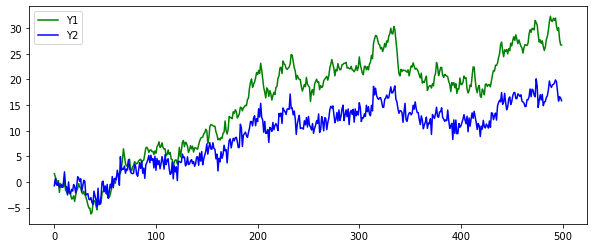

In [2]:
# 데이터 생성
np.random.seed(1)
Y1 = np.random.randn(500).cumsum()
Y2 = 0.6 * Y1 + np.random.randn(500)
Y = 0.6 * Y1 - Y2

# Y1과 Y2 시각화
plt.figure(figsize=(10,4))
plt.plot(Y1, 'g', label='Y1')
plt.plot(Y2, 'b', label='Y2')
plt.legend()
plt.show()

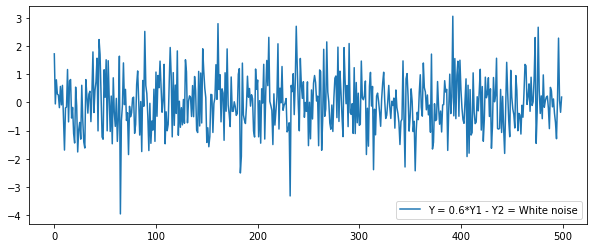

In [3]:
# Y시각화, Y는 𝑒2𝑡(White noise)이다.

plt.figure(figsize=(10,4))
plt.plot(Y, label='Y = 0.6*Y1 - Y2 = White noise')
plt.legend()
plt.show()

In [5]:
# VECM 공적분 확인
coint_result = sm.tsa.coint(Y1, Y2)
pd.DataFrame([coint_result[0], coint_result[1]], index=['통계량', 'p-value'], columns=['output'])

,output
통계량,-22.68
p-value,0.00


## 삼성전자와 삼성전자 우선주를 활용한 공적분 실습

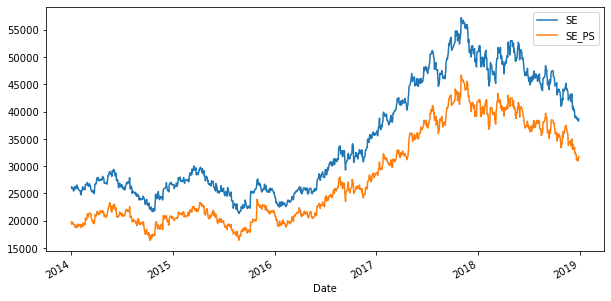

In [6]:
# 필요 모듈 로딩
import pandas_datareader.data as web
import datetime

# 전처리
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2018,12,31)
raw1 = web.DataReader("005930.KS", 'yahoo', start, end)
raw2 = web.DataReader("005935.KS", 'yahoo', start, end)
raw = pd.concat([raw1.Close, raw2.Close], axis=1).dropna()
raw.columns = ['SE', 'SE_PS']

# 삼성전자와 삼성전자 우선주 시각화
raw.plot(figsize=(10,5))
plt.show()

In [9]:
# 삼성전자 우선주로 삼성전자 OLS 회귀분석
Y = raw.SE
X = raw.SE_PS
X = sm.add_constant(X)
fit = sm.OLS(Y, X).fit()
display(fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     SE   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.307e+05
Date:                Sun, 12 Jun 2022   Prob (F-statistic):               0.00
Time:                        22:40:56   Log-Likelihood:                -10199.
No. Observations:                1225   AIC:                         2.040e+04
Df Residuals:                    1223   BIC:                         2.041e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        914.9126     97.671      9.367      0.000     723.291    1106.534
SE_PS          1.2147      0.003    361.518      0.000       1.208       1.221
==============================================================================
Omnibus:                       11.529   Durbin-Watson:                   0.124
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               10.711
Skew:                          -0.186   Prob(JB):                      0.00472
Kurtosis:                       2.733   Cond. No.                     9.94e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

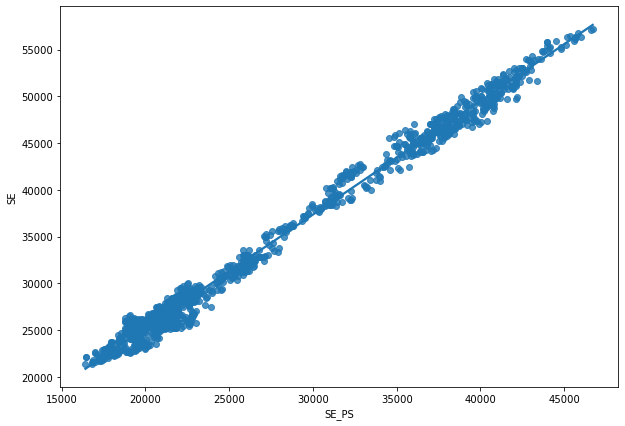

In [10]:
# 회귀분석 시각화
import seaborn as sns
plt.figure(figsize=(10,7))
sns.regplot(x='SE_PS', y='SE', data = raw)
plt.show()

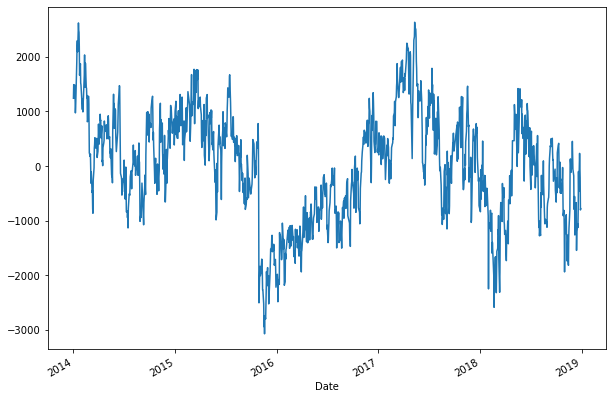

Test Statistics        -3.87
p-value                 0.00
Used Lag                8.00
Used Observations   1,216.00
dtype: float64

In [18]:
# 회귀식의 잔차 시각화
plt.figure(figsize=(10,7))
fit.resid.plot()
plt.show()

# 회귀식 잔차 비정상성 테스트
display(pd.Series(sm.tsa.stattools.adfuller(fit.resid)[0:4], 
                  index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations']))

In [19]:
# 위에서 삼전과 삼전 우선주를 회귀분석 후 잔차를 구함
# 잔차에 대해 adf테스트 결과 stationary하면 삼전과 삼전 우선주는 공적분 관계
# 위의 과정을 요약한게 sm.tsa.coin 함수

# 귀무가설 : no cointegration
# coin()에 들어오는 시계열은 1차 차분시 정상시계열이 되는걸로 가정, assumed to be integrated of order 1, I(1).
# trend='c' : constant, autolag='aic'가 디폴트임
coint_result = sm.tsa.coint(raw.SE, raw.SE_PS)
pd.DataFrame([coint_result[0], coint_result[1]], index=['statistics', 'p-value'], columns=['output'])

,output
statistics,-3.87
p-value,0.01


# Granger Causality

## 실습: 닭과 달걀의 생산량을 통한 Granger 인과관계 이해

**닭과 달걀 중에 시간적 순서로 봤을 때 어떤게 선행성이 있는지 보는 
시간적 인과관계를 본다.**

In [2]:
# 데이터 로딩
location = "C:/Users/wkdgu/시계열/All-About-Time-Series-Analysis-master/Data/ChickenEggProduction/Chicken_Egg_Production.txt"
raw_all = pd.read_csv(location, sep='\t')
raw_all.head()

,Year,Chicken,Egg
0,1930,468491,3581
1,1931,449743,3532
2,1932,436815,3327
3,1933,444523,3255
4,1934,433937,3156


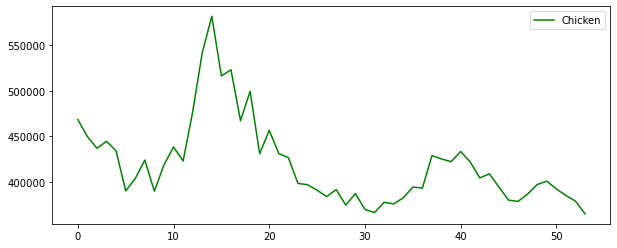

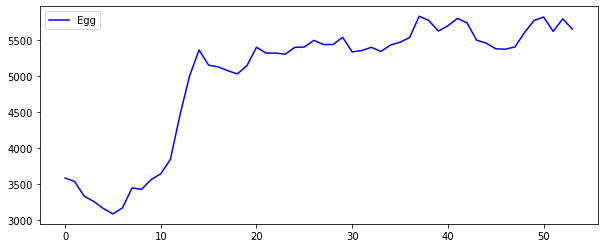

In [6]:
# 데이터 시각화
# 닭 생산량
plt.figure(figsize=(10,4))
plt.plot(raw_all['Chicken'], 'g', label='Chicken')
plt.legend()
plt.show()

# 달걀 생산량
plt.figure(figsize=(10,4))
plt.plot(raw_all['Egg'], 'b', label='Egg')
plt.legend()
plt.show()

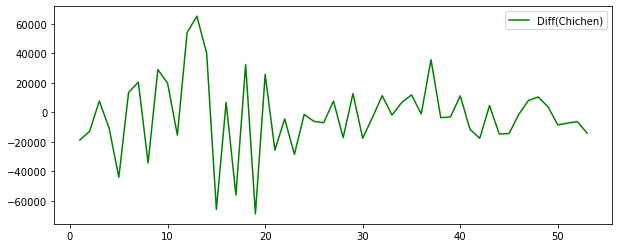

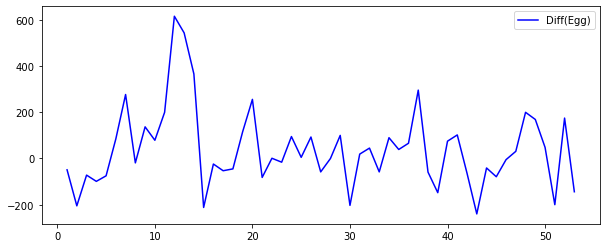

In [7]:
# 1차 차분후 시각화
plt.figure(figsize=(10,4))
plt.plot(raw_all['Chicken'].diff(1), 'g', label='Diff(Chichen)')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(raw_all['Egg'].diff(1), 'b', label='Diff(Egg)')
plt.legend()
plt.show()

In [33]:
# Granger Causality는 두번째 컬럼이 첫번째 컬럼에 영향을 주는지 테스트

# Egg가 Chicken에 영향을 주는지 테스트
# Chicken이 첫번째 , Egg가 두번째 컬럼
print('[Egg -> Chicken]')
granger_result1 = sm.tsa.stattools.grangercausalitytests(raw_all.diff(1).dropna().iloc[:, 1:].values, maxlag=3, verbose=True)

# Chicken이 Egg에 영향을 주는지 테스트
# Egg가 첫번째 , Chicken이 두번째 컬럼
print('\n[Chicken -> Egg]')
granger_result2 = sm.tsa.stattools.grangercausalitytests(raw_all.diff(1).dropna().iloc[:, [2,1]].values, maxlag=3, verbose=True)

# 의사결정
# 닭이 달걀을 낳으면 그 수는 약 3년후까지 닭의 수에 영향을 준다
# 닭의 수가 많아진다고해서 달걀을 많이 낳지는 않는다
# 달걀 -> 닭 (Granger Causality)

[Egg -> Chicken]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.3694 , p=0.0023  , df_denom=49, df_num=1
ssr based chi2 test:   chi2=11.0043 , p=0.0009  , df=1
likelihood ratio test: chi2=9.9819  , p=0.0016  , df=1
parameter F test:         F=10.3694 , p=0.0023  , df_denom=49, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9196  , p=0.0268  , df_denom=46, df_num=2
ssr based chi2 test:   chi2=8.6913  , p=0.0130  , df=2
likelihood ratio test: chi2=8.0254  , p=0.0181  , df=2
parameter F test:         F=3.9196  , p=0.0268  , df_denom=46, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9318  , p=0.0441  , df_denom=43, df_num=3
ssr based chi2 test:   chi2=10.2270 , p=0.0167  , df=3
likelihood ratio test: chi2=9.3049  , p=0.0255  , df=3
parameter F test:         F=2.9318  , p=0.0441  , df_denom=43, df_num=3

[Chicken -> Egg]

Granger Causality
number of lags (no zero) 1
ssr based F test:  

## 실습: 삼성전자와 삼성전자 우선주 Granger 인과관계 이해

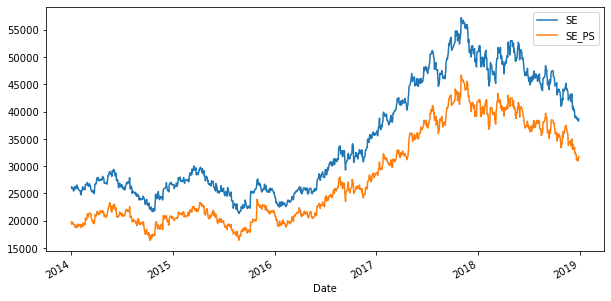

In [34]:
# 데이터 로딩
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2018, 12, 31)
raw1 = web.DataReader("005930.KS", 'yahoo', start, end) # 삼성전자
raw2 = web.DataReader("005935.KS", 'yahoo', start, end) # 삼성전자 우

# 데이터 시각화
raw = pd.concat([raw1.Close, raw2.Close], axis = 1).dropna()
raw.columns = ['SE', 'SE_PS']
raw.plot(figsize=(10,5))
plt.show()

In [42]:
# 데이터 adf테스트
# SE : 삼성전자, SE_PS : 삼성전자우
print('삼성전자 adf테스트')
print(pd.Series(sm.tsa.stattools.adfuller(raw['SE'], regression='nc', maxlag=3, autolag=None)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations']))
print('')

print('삼성전자우 adf테스트')
print(pd.Series(sm.tsa.stattools.adfuller(raw['SE_PS'], regression='nc', maxlag=3, autolag=None)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations']))

# adf결과 두 데이터에 unitroot 존재

삼성전자 adf테스트
Test Statistics         0.35
p-value                 0.79
Used Lag                3.00
Used Observations   1,221.00
dtype: float64

삼성전자우 adf테스트
Test Statistics         0.33
p-value                 0.78
Used Lag                3.00
Used Observations   1,221.00
dtype: float64


In [43]:
# 1차 차분후 adf테스트
# SE : 삼성전자, SE_PS : 삼성전자우
print('삼성전자 adf테스트')
print(pd.Series(sm.tsa.stattools.adfuller(raw['SE'].diff(1).dropna(), regression='nc', maxlag=3, autolag=None)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations']))
print('')

print('삼성전자우 adf테스트')
print(pd.Series(sm.tsa.stattools.adfuller(raw['SE_PS'].diff(1).dropna(), regression='nc', maxlag=3, autolag=None)[0:4], 
                         index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations']))

# adf테스트 결과 unitroot 없음

삼성전자 adf테스트
Test Statistics       -19.01
p-value                 0.00
Used Lag                3.00
Used Observations   1,220.00
dtype: float64

삼성전자우 adf테스트
Test Statistics       -19.43
p-value                 0.00
Used Lag                3.00
Used Observations   1,220.00
dtype: float64


In [46]:
# 1차 차분한 데이터로 Granger Causality 테스트 진행

print('\n[삼성전자우 -> 삼성전자]')
granger_result1 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().values, maxlag = 4, verbose=True)
print('\n[삼성전자 -> 삼성전자우]')
granger_result2 = sm.tsa.stattools.grangercausalitytests(raw.diff(1).dropna().iloc[:, [1,0]].values, maxlag=4, verbose=True)


[삼성전자우 -> 삼성전자]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0197  , p=0.0825  , df_denom=1220, df_num=1
ssr based chi2 test:   chi2=3.0271  , p=0.0819  , df=1
likelihood ratio test: chi2=3.0233  , p=0.0821  , df=1
parameter F test:         F=3.0197  , p=0.0825  , df_denom=1220, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4854  , p=0.0115  , df_denom=1217, df_num=2
ssr based chi2 test:   chi2=9.0076  , p=0.0111  , df=2
likelihood ratio test: chi2=8.9746  , p=0.0113  , df=2
parameter F test:         F=4.4854  , p=0.0115  , df_denom=1217, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4711  , p=0.0156  , df_denom=1214, df_num=3
ssr based chi2 test:   chi2=10.4734 , p=0.0149  , df=3
likelihood ratio test: chi2=10.4287 , p=0.0153  , df=3
parameter F test:         F=3.4711  , p=0.0156  , df_denom=1214, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:        